In [2]:
import spreg
from spreg import OLS
from spreg import ML_Error, ML_Error_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import robust_scale
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate

In [14]:
db = libpysal.io.open('../raw_data/basic_model_preds_gdf.dbf','r')
df = gpd.read_file('../raw_data/basic_model_preds_gdf.shp')

In [4]:
df.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
       'public_hou', 'five_y_pls', 'child_pov', 'dyn_unempl', 'air', 'bio',
       'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations', 'geometry'],
      dtype='object')

In [15]:
columns = [
        'public_tra', 'eating', 'culture', 'community', 'health_car',
        'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
        'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
        'public_hou', 'five_y_pls', 'dyn_unempl', 'air', 'bio',
        'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
        'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations'
        ]
#regimes = db.by_col("label")

In [16]:
y = np.array(db.by_col('child_pov')).T
x_names = columns
X = np.array([db.by_col(var) for var in x_names]).T

In [20]:
X.shape

(536, 30)

In [9]:
queen = libpysal.weights.Queen.from_dataframe(df)

In [21]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(df, 5000, geom_col='geometry', binary=False)

In [29]:
rook = libpysal.weights.Rook.from_dataframe(df)

In [22]:
mlerror = ML_Error(y,
                   X,
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='selected_ds',
                   name_w='inv_dist')

In [23]:
print(mlerror.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          31
S.D. dependent var  :     16.6701                Degrees of Freedom    :         505
Pseudo R-squared    :      0.7890
Sigma-square ML     :      58.425                Log likelihood        :   -1850.709
S.E of regression   :       7.644                Akaike info criterion :    3763.419
                                                 Schwarz criterion     :    3896.227

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------------------------------------

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

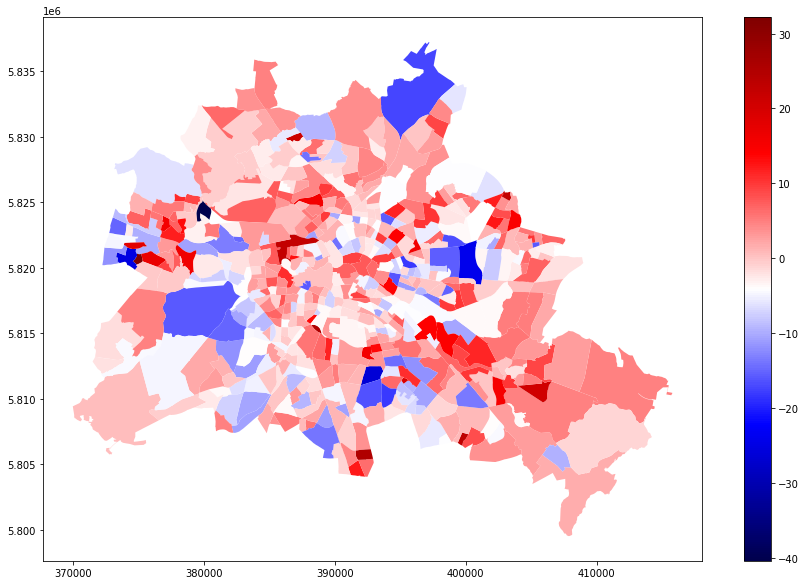

In [26]:
# Adding a resituals column to sample dataframe
res = df[['PLR_ID', 'geometry']]
res['residuals_mlerror'] =mlerror.u
# plotting residuals - red = underestimation, blue = overestimation
res.plot('residuals_mlerror', figsize=(15,10), cmap= 'seismic', legend=True)

In [27]:
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = east.dissolve()

eastwest = east.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

/var/folders/sx/4s_zvfwj1xddph7py3s74ych0000gn/T/ipykernel_23285/1633683294.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eastwest = east.append(west)


In [28]:
df_east = df.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

df = df.merge(df_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [29]:
mlerror_regimes = ML_Error_Regimes(y,
                   X,
                    regimes=df['east'],
                   name_x=columns,
                   name_y='child poverty',
                   w=inv_dist,
                   name_ds='selected_ds',
                   name_w='inv_dist')

/Users/Safia/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [30]:
print(mlerror_regimes.summary) # only significant difference in the coefficients is in green volume

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR - REGIMES (METHOD = full)
-----------------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          62
S.D. dependent var  :     16.6701                Degrees of Freedom    :         474
Pseudo R-squared    :      0.8063
Sigma-square ML     :      53.663                Log likelihood        :   -1827.942
S.E of regression   :       7.326                Akaike info criterion :    3779.883
                                                 Schwarz criterion     :    4045.500

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------

In [33]:
mae(df.child_pov, mlerror.u)

24.5666732857316

In [ ]:
# Adding a resituals column to sample dataframe
df['residuals_mlerror_reg'] = mlerror_regimes.u

# plotting residuals - red = underestimation, blue = overestimation
df.plot('residuals_mlerror_reg', figsize=(15,10), cmap= 'seismic', legend=True)